# Определение тональности текстов отзывов на сайте YELP сетью LSTM

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 


In [ ]:
num_words = 10000
max_review_len = 100

### Загрузка данных

In [ ]:
!wget https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1 -O yelp_review_polarity_csv.tgz

In [ ]:
!tar -xvf yelp_review_polarity_csv.tgz

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


### Просматриваем данные

In [ ]:
!cat yelp_review_polarity_csv/readme.txt

In [ ]:
!head yelp_review_polarity_csv/train.csv

In [ ]:
!head yelp_review_polarity_csv/test.csv

In [ ]:
!wc -l yelp_review_polarity_csv/train.csv
!wc -l yelp_review_polarity_csv/test.csv

560000 yelp_review_polarity_csv/train.csv
38000 yelp_review_polarity_csv/test.csv


### Загружаем данные в память

In [ ]:
train = pd.read_csv('yelp_review_polarity_csv/train.csv', header=None, names=['Class', 'Review'])

In [ ]:
train.head(5)

In [ ]:
reviews = train['Review']
reviews[:5]

In [ ]:
y_train = train['Class'] - 1
y_train.head(5)

0    0
1    1
2    0
3    0
4    1
Name: Class, dtype: int64

### Токенизация текста

In [ ]:
tokenizer = Tokenizer(num_words=num_words)

In [ ]:
tokenizer.fit_on_texts(reviews)

In [ ]:
sequences = tokenizer.texts_to_sequences(reviews)

In [ ]:
index = 0
print(reviews[index])
print(sequences[index])

In [ ]:
tokenizer.word_index['unfortunately']

707

### Ограничиваем длину отзыва

In [ ]:
x_train = pad_sequences(sequences, maxlen=max_review_len)

In [ ]:
x_train[:3]

array([[   7,    1,  137,  112,   24,   18,   27,  189,   80, 3128,   10,
        2636,   34, 1416,  462,  129,    8,  519,   13,  177,  129,  803,
          88, 3812,    1,  446,    8,  392,  841,  115,  360,    7, 4136,
        1438,    4,   43,   59, 1266,  118,   95,   46,    9,   13,   49,
        1687,    4,  418,   18,    8,    3,   23,  563,  178,   16,  460,
          18,  189,   80, 3128,    2,    3,   40,   78,   43,    8,   20,
          23,  644, 1343,   20,   23, 3252,   18, 2921,  637,  227,  430,
         476, 4312,    1,  446,   63,    2,   22,  215,    1,   63,   18,
        2269,   13,    3,  249,   13,    3,   23,    4,  163,  939,  115,
         237],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   69,  116,
           4,  939,    9,   94,  201,  274,    3,  142,    3,    6,   44,
           7,  177, 2084, 3252,   47,   62,  422,   25, 1334,   69,   51,
          94,    1,  274,    2,   11,   61,   37,   56,    1,  219, 1403,
           8,   11,   7

### Создаем нейронную сеть

In [ ]:
model = Sequential()
model.add(Embedding(num_words, 64, input_length=max_review_len))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

### Обучаем нейронную сеть

In [ ]:
model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=5,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback])

Epoch 1/5
3938/3938 [==============================] - 167s 40ms/step - loss: 0.2627 - accuracy: 0.8880 - val_loss: 0.1276 - val_accuracy: 0.9512

Epoch 00001: val_accuracy improved from -inf to 0.95118, saving model to best_model.h5
Epoch 2/5
3938/3938 [==============================] - 145s 37ms/step - loss: 0.1456 - accuracy: 0.9439 - val_loss: 0.1137 - val_accuracy: 0.9564

Epoch 00002: val_accuracy improved from 0.95118 to 0.95639, saving model to best_model.h5
Epoch 3/5
3938/3938 [==============================] - 145s 37ms/step - loss: 0.1192 - accuracy: 0.9547 - val_loss: 0.1153 - val_accuracy: 0.9567

Epoch 00003: val_accuracy improved from 0.95639 to 0.95670, saving model to best_model.h5
Epoch 4/5
3938/3938 [==============================] - 145s 37ms/step - loss: 0.1004 - accuracy: 0.9624 - val_loss: 0.1121 - val_accuracy: 0.9575

Epoch 00004: val_accuracy improved from 0.95670 to 0.95750, saving model to best_model.h5
Epoch 5/5
3938/3938 [==============================] - 

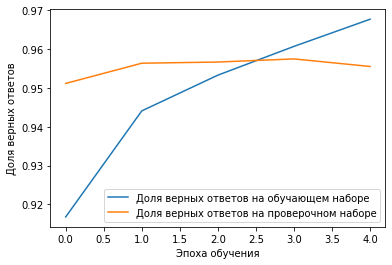

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model.load_weights(model_save_path)

### Загружаем набор данных для тестирования

In [ ]:
test = pd.read_csv('yelp_review_polarity_csv/test.csv', 
                    header=None, 
                    names=['Class', 'Review'])

In [ ]:
test.head(5)

,Class,Review
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['Review'])

In [ ]:
x_test = pad_sequences(test_sequences, maxlen=max_review_len)

In [ ]:
x_test[:3]

array([[   9,    1,  546,  148,  274,  165,    2, 1221,    4,   14,  137,
          18,  289,   38, 8346, 2311,  257,  511,   28, 1167,    2,  113,
          60,  568,  520, 1426,   16,   11,   44,   31,   13,    3,   82,
          22,  249,   38,    3,  144,  173,  694, 2235,    7,   40,   72,
           7,   14,   80, 2540, 5951,   23,   69,    9,   21,   14,    7,
        1558,    2,   23, 1696,   14, 1894, 1775,  470,   17,   45,   14,
          52,    2, 1346, 5923,   95,   37,   69,   91, 1024,    2,  311,
          48,    4,   32,    4, 1480, 1037,   19,   40, 4124,    1,  317,
         127,    8,  562,    5,  203,  114,   99,    8,   90,   10, 1168,
         274],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  182, 1243,    3,   24,
          59,  728,    4,   43,  159, 2073,    2,   24,    4,  154,    5,
         315,  190,   4

In [ ]:
y_test = test['Class'] - 1

In [ ]:
y_test.head(5)

0    1
1    0
2    1
3    0
4    1
Name: Class, dtype: int64

### Оцениваем качество работы сети на тестовом наборе данных

In [ ]:
model.evaluate(x_test, y_test, verbose=1)

1188/1188 [==============================] - 11s 9ms/step - loss: 0.1369 - accuracy: 0.9483


[0.13688378036022186, 0.9483420848846436]

### Оцениваем тональность на собственном отзыве

In [ ]:
text = '''The Flower restaurant is beautiful. It’s a big nice place. 
The food is really tasty.  The host and waiters are affable. 
I will try to come as often as possible!
'''

In [ ]:
sequence = tokenizer.texts_to_sequences([text])

In [ ]:
data = pad_sequences(sequence, maxlen=max_review_len)
data

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    1, 4690,  104,   11,  620,
           5,  219,   92,   31,    1,   29,   11,   61,  352,    1, 1526,
           2, 1713,   28,    3,   66,  121,    4,  124,   35,  668,   35,
        1083]], dtype=int32)

In [ ]:
result = model.predict(data)
result

array([[0.98658574]], dtype=float32)

In [ ]:
if result[[0]] < 0.5:
    print('Отзыв отрицательный')
else:
    print('Отзыв положительный')

Отзыв положительный
